Created on Tuesday 12 January 2021

Group 5 - Classification

@authors : F.B

In [ ]:
!python3 -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/G5 Inter-Promo 2021/Données/Input")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from nltk.stem import  WordNetLemmatizer
lemmer=WordNetLemmatizer()
import nltk
nltk.download('wordnet')

from textblob import TextBlob
import spacy

import fr_core_news_md
nlp = fr_core_news_md.load()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
bow :pd.DataFrame= pd.read_json("g3_BOW_v1.json")
bow.head()

,art_id,art_content_clean_without_lem,abonnement,abord,aborde,aborder,abordes,aboutir,abri,absence,absolue,absolument,academie,academique,academiques,acceder,accelerateur,acceleration,accelere,acceleree,accelerer,accent,accentuer,acceptable,accepte,accepter,acces,accessibilite,accessible,accessibles,accident,accidents,accompagnant,accompagne,accompagnee,accompagnement,accompagnent,accompagner,accompagnes,accompli,...,volets,volontaire,volontaires,volontariste,volonte,volume,volumes,vont,vote,votee,voter,votes,voudrais,voulais,voulez,vouloir,voulons,voulu,voyage,voyez,voyons,vrai,vraie,vraies,vraiment,vrais,vu,vue,vues,vulnerables,web,week,www,xxie,yeux,yves,zero,zone,zones,œuvre
1,1,fncdg andcdg publie septembre eme edition pano...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,malgre levee mesures confinement mai plupart m...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,25,quels etaient objectifs poursuivis gouvernemen...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
27,27,journee thematique lieu durant salon preventic...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,28,ere journee thematique region theme vers nouve...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# this function allows you to lemmatize English words

def lemmatization(word : str) -> str:
  """
  parameters
    word : word to lemmatize
  Output
    word : lemmatized word
  """
  for pos in ['a', 's', 'r', 'n', 'v']:
    word=lemmer.lemmatize(word, pos)
  return word

In [ ]:
# This function allows you to clean up keywords

def clean_keyword(link_keyword : str, bow : pd.DataFrame = bow) -> list:
  """
  Parameters :
      link_keyword : link of keyword
      bow : bow dataframe 
    Output : 
      list_key_word : list of cleaned keywords 
  """

  df_lexique: pd.DataFrame = pd.read_csv(link_keyword, sep="  ", header=None)
  df_lexique.columns: list = ['key_word']
  list_key_word = df_lexique.key_word.values.tolist()
  list_key_word_need : list = []

  columns_bow = bow.columns
  stop_word =[ 'le', 'par', 'les', 'du', 'la', 'de']

  #
  for key in list_key_word :
    for k in key.split():
      if k in columns_bow and k not in stop_word:
        list_key_word_need.append(k)

    #
    blob = TextBlob(key)
    try :
      if blob.detect_language()=='fr':
        k_npl=nlp(key)
        for j in k_npl:
          jj = j.lemma_
          if jj in columns_bow and k not in stop_word:
            list_key_word_need.append(jj)
      elif blob.detect_language()=='en' :
        for k in key.split():
          kk = lemmatization(k)
          if kk in columns_bow and kk not in stop_word:
            list_key_word_need.append(kk)
    except :
      pass 



  list_key_word_need = pd.unique(list_key_word_need).tolist()
  return list_key_word_need

link_keyword = "/content/drive/MyDrive/G5 Inter-Promo 2021/Ressources/Lexique_Innovation.txt"
list_key_word_need = clean_keyword(link_keyword)
list_key_word_need [ : 5]

['innovation', 'migration', 'automatique', 'ligne', 'produits']

In [ ]:
# This function projects the bow dataframe onto the keywords, 
# then normalises and calculates the sum of the keywords for each item. 

def sum_keyword(data: pd.DataFrame = bow)-> pd.DataFrame:
  """
  Parameters :
    data : default the bow dataframe 
  Output :
    data : dataframe
  
  """
  data = data [list_key_word_need]
  data_scale = scaler.fit_transform(data)
  data = pd.DataFrame(data_scale, index=data.index, columns=data.columns)
  data['sum_keyword'] = np.sum(data.T).tolist()
  return data

In [ ]:
data = sum_keyword()
data.head()

,innovation,migration,automatique,ligne,produits,iot,recherche,machine,learning,ia,intelligence,artificielle,traitement,langage,analyse,virtuelle,mixte,sociale,si,algorithmes,description,base,data,design,reconnaissance,big,digital,cloud,connaissances,interface,smart,city,ville,futur,industrie,optimisation,moteur,experience,web,durable,interfaces,intelligentes,digitalisation,saas,fusion,aide,code,autonome,it,conjoncture,enjeux,prospective,nouvelle,sum_keyword
1,-0.307185,-0.077243,-0.137089,-0.285899,-0.25963,-0.084275,-0.238411,-0.092095,-0.077846,-0.065807,-0.157214,-0.091178,-0.216439,-0.104335,-0.291058,-0.073521,-0.108423,-0.237480,-0.433572,-0.092406,-0.093734,-0.325345,-0.145877,-0.057744,-0.181925,-0.09881,-0.160644,-0.157079,-0.158961,-0.123051,-0.120458,-0.1012,-0.232011,-0.218301,-0.17259,-0.159805,-0.169749,-0.307239,-0.170033,-0.217577,-0.093316,-0.088848,-0.143614,-0.114537,-0.121865,-0.256955,-0.187284,-0.112081,-0.073212,-0.096691,-0.307069,-0.129983,-0.456441,-8.985135
2,-0.307185,-0.077243,-0.137089,-0.285899,-0.25963,-0.084275,-0.238411,-0.092095,-0.077846,-0.065807,-0.157214,-0.091178,-0.216439,-0.104335,-0.291058,-0.073521,-0.108423,-0.237480,-0.433572,-0.092406,-0.093734,-0.325345,-0.145877,-0.057744,-0.181925,-0.09881,-0.160644,-0.157079,-0.158961,-0.123051,-0.120458,-0.1012,-0.232011,-0.218301,-0.17259,-0.159805,-0.169749,-0.307239,-0.170033,-0.217577,-0.093316,-0.088848,-0.143614,-0.114537,-0.121865,-0.256955,-0.187284,-0.112081,-0.073212,-0.096691,0.786104,-0.129983,-0.456441,-7.891962
25,-0.307185,-0.077243,-0.137089,-0.285899,-0.25963,-0.084275,-0.034349,-0.092095,-0.077846,-0.065807,-0.157214,-0.091178,-0.216439,-0.104335,-0.291058,-0.073521,-0.108423,0.329716,-0.073552,-0.092406,-0.093734,1.340747,-0.145877,-0.057744,-0.181925,-0.09881,-0.160644,-0.157079,-0.158961,-0.123051,-0.120458,-0.1012,-0.232011,-0.218301,-0.17259,3.736033,-0.169749,-0.307239,-0.170033,-0.217577,-0.093316,-0.088848,-0.143614,-0.114537,2.531337,0.792742,-0.187284,-0.112081,-0.073212,-0.096691,0.786104,-0.129983,2.040558,5.001142
27,-0.307185,-0.077243,-0.137089,0.734317,-0.25963,-0.084275,-0.238411,-0.092095,-0.077846,-0.065807,-0.157214,-0.091178,-0.216439,-0.104335,-0.291058,-0.073521,-0.108423,-0.237480,-0.433572,-0.092406,-0.093734,-0.325345,-0.145877,-0.057744,-0.181925,-0.09881,-0.160644,-0.157079,-0.158961,-0.123051,-0.120458,-0.1012,-0.232011,-0.218301,-0.17259,-0.159805,-0.169749,-0.307239,-0.170033,-0.217577,-0.093316,-0.088848,-0.143614,-0.114537,-0.121865,-0.256955,-0.187284,-0.112081,-0.073212,-0.096691,0.786104,-0.129983,-0.456441,-6.871746
28,-0.307185,-0.077243,-0.137089,-0.285899,-0.25963,-0.084275,-0.238411,-0.092095,-0.077846,-0.065807,-0.157214,-0.091178,-0.216439,-0.104335,-0.291058,-0.073521,-0.108423,-0.237480,-0.433572,-0.092406,-0.093734,-0.325345,-0.145877,-0.057744,-0.181925,-0.09881,-0.160644,-0.157079,-0.158961,-0.123051,-0.120458,-0.1012,-0.232011,-0.218301,-0.17259,-0.159805,-0.169749,-0.307239,-0.170033,-0.217577,-0.093316,-0.088848,-0.143614,-0.114537,-0.121865,-0.256955,-0.187284,-0.112081,-0.073212,-0.096691,-0.307069,-0.129983,-0.456441,-8.985135


In [ ]:
# Distribution of the sum of keywords
data.sum_keyword.describe()

count    7.533000e+03
mean    -8.642437e-16
std      1.284689e+01
min     -8.985135e+00
25%     -7.891962e+00
50%     -4.373187e+00
75%      3.327501e+00
max      2.449475e+02
Name: sum_keyword, dtype: float64

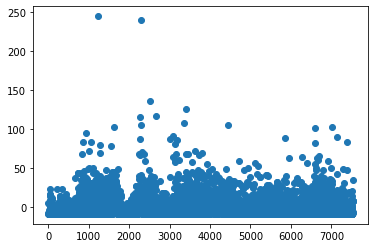

In [ ]:
# Visualization
plt.scatter(range(len(data)),data.sum_keyword.values.tolist())

In [ ]:
# This function with a threshold separates the dataframe in 2. 
# Its explanatory variables and its variable to be explained

def threshold_breakdown(threshold : int, data : pd.DataFrame) -> tuple :
  """
  Parameter :
    threshold : threshold
    data : dataframe
  Output :
    X, y 
  """
  # Thresholding
  index_no_innovation = data[data['sum_keyword']<=threshold].index.tolist()
  index_innovation = data[data['sum_keyword']>threshold].index.tolist()

  # Labelling
  data.loc[index_no_innovation, 'label_innovation'] = 0
  data.loc[index_innovation, 'label_innovation'] = 1

  # Training
  X = data.drop(['label_innovation','sum_keyword'], axis=1)
  y = data.label_innovation.values
  return X, y

100%|██████████| 3/3 [01:52<00:00, 37.66s/it]


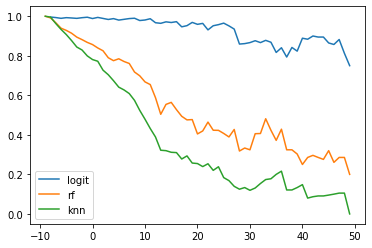

CPU times: user 1min 53s, sys: 4.36 s, total: 1min 58s
Wall time: 1min 53s


In [ ]:
# Searching for the optimal threshold to differentiate
#  between innovative and non-innovative products per model. 
%%time
data : pd.DataFrame = sum_keyword()
m :int = int(min(data.sum_keyword.tolist()))-1

scores :list = []
ss :list = []

models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier(),
    'knn': KNeighborsClassifier()
}

for j in tqdm(models.keys()):
  score : list = []
  s : list = []
  for i in range(m, 50,1):

    X, y = threshold_breakdown(i,  data)
    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    try :
      model = models[j]
      model.fit(X_train, Y_train)
      y_pred = model.predict(X_val)
      score.append(f1_score(Y_val, y_pred))
      s.append(i)
    except :
      pass
  scores.append(score)
  ss.append(s)
  plt.plot(s, score, label=j)
  plt.legend()
plt.show()

In [ ]:
threshold = -5
data = sum_keyword()
X, y = threshold_breakdown(threshold,  data)

In [ ]:
# this function allows you to train a model either by cross validation 
# and display its accuracy and f1_score or by simple training 
# and display its accuracy and f1_score and also its confusion matrix if you wish.

def training(model, if_plot : bool = False, if_val_cross : bool = False) :
  """
  Parameters :
    model : model
    if_plot : if you want to display your confusion matrix
    if_val_cross : if you want to train by cross-validation
    Output :
  """
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))

  else :

    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No innovation', 'Innovation']);

accuracy ...
0.9924778761061946
f1_score ...
0.9928601427971441


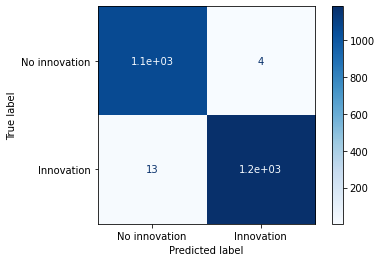

In [ ]:
# Logit 

model = LogisticRegression()
training(model, True)

In [ ]:
# Logit 

training(model, False, True)

accuracy ...
[0.99469144 0.97876576 0.99601858 0.99468792 0.99136786]
f1_score ...
[0.99499374 0.97969543 0.99626866 0.99498747 0.99185974]


# The most important keywords

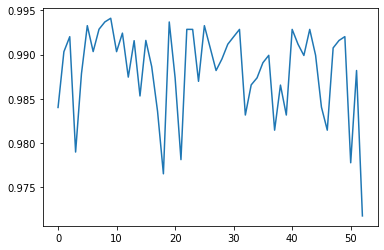

CPU times: user 3.94 s, sys: 2.53 s, total: 6.47 s
Wall time: 3.32 s


In [ ]:
# Delete a keyword and see its impact on the f1_score
%%time

score : list = []

columns = data.columns.tolist()
columns.remove('label_innovation')
columns.remove('sum_keyword')

for col in columns:

  X = data.drop(['label_innovation','sum_keyword',col], axis=1)
  y = data.label_innovation.values
  X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
  
  try :
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)
    score.append(f1_score(Y_val, y_pred))
  except :
    pass
plt.plot(score)
#plt.legend()
plt.show()

In [ ]:
# The most important keywords

ind : list = np.where(np.array(score)<0.99)[0].tolist()
key_importants : list = []
for i in ind:
  col = columns[i]
  print(col)
  key_importants.append(col)

innovation
ligne
produits
traitement
analyse
mixte
sociale
si
description
base
reconnaissance
cloud
connaissances
ville
futur
industrie
optimisation
moteur
experience
web
durable
digitalisation
fusion
aide
code
enjeux
prospective
nouvelle


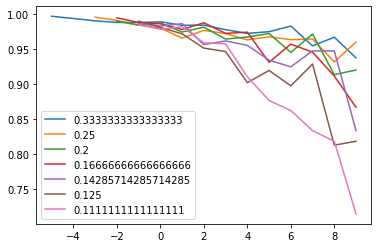

CPU times: user 7.43 s, sys: 4.79 s, total: 12.2 s
Wall time: 6.3 s


In [ ]:
# For each weight assigned to the keywords, the least important ones, 
# display the f1_score in relation to the threshold.
%%time

data_copy : pd.DataFrame = data.copy()

weigths = [1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9]
for w in  weigths:
  for col in data.columns:
    if col in key_importants :
      data_copy[col]= data_copy[col]*(1-w)
    else :
      data_copy[col]= data_copy[col]*w

  data_copy.drop(['sum_keyword', 'label_innovation'], axis=1, inplace=True)
  data_copy['sum_keyword'] = np.sum(data_copy.T).tolist()

  m : int = int(min(data_copy.sum_keyword.tolist())) - 1
  score : list = []
  s : list = []
  for i in range(m,10,1):

    X, y = threshold_breakdown(i,  data_copy)
    
    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    try :
      model = LogisticRegression()
      model.fit(X_train, Y_train)
      y_pred = model.predict(X_val)
      score.append(f1_score(Y_val, y_pred))
      s.append(i)
    except :
      pass

  plt.plot(s, score, label=w)
  plt.legend()
plt.show()

In [ ]:
threshold : int = -5
data : pd.DataFrame = sum_keyword()
data_copy : pd.DataFrame = data.copy()

w : float = 1/3
for col in data.columns:
  if col in key_importants :
    data_copy[col]= data[col]*(1-w)
  else :
    data_copy[col]= data[col]*w

data_copy.drop(['sum_keyword'], axis=1, inplace=True)
data_copy['sum_keyword'] = np.sum(data_copy.T).tolist()

X, y = threshold_breakdown(threshold,  data_copy)

accuracy ...
0.9946902654867257
f1_score ...
0.9968701095461658


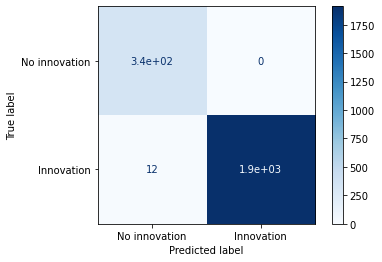

In [ ]:
model = LogisticRegression()
training(model, True)

In [ ]:
training(model, False, True)

accuracy ...
[0.96084937 0.99270073 0.99270073 0.97875166 0.99734396]
f1_score ...
[0.9762957  0.99566417 0.99566417 0.9872814  0.99842767]


In [ ]:
# We notice that the f1_score is approximately equal to 1 and the recall is equal to 1. 
# So the labeling is good.

# Output 

In [ ]:
label = pd.DataFrame()
label['art_id'] = bow.art_id.tolist()
label['label_innovation'] = data_copy.label_innovation.tolist()
label.head()

,art_id,label_innovation
0,1,0.0
1,2,1.0
2,25,1.0
3,27,1.0
4,28,0.0


In [ ]:
label['label_innovation'] = label['label_innovation'].astype(int)
label.head()

,art_id,label_innovation
0,1,0
1,2,1
2,25,1
3,27,1
4,28,0


In [ ]:
label.to_csv("../Output/label_supervised.csv", index=False)